# CDC → Public Health Signals (Socrata-preconfigured, resilient)

This notebook pulls CDC data to inform RWE governance (timeliness, completeness, feasibility).

**Primary source (preconfigured):**  
- Provisional COVID-19 Death Counts by Week Ending Date and State — resource `muzy-jte6`  
- Date field: `week_ending_date`; Geo: `state`

**Resilience:**  
1) Socrata (`muzy-jte6`) → 2) FluView national ILI CSV → 3) Synthetic sample

**Artifacts saved:**  
- `data/cdc_summary.json` (raw rows for reuse)  
- `data/cdc_cases_flat.csv` (tidy slice)  
- `data/cdc_cases_summary.json` (metrics + dates + top entities)

In [143]:
import sys, os
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)
print("Repo root on sys.path:", repo_root)

Repo root on sys.path: /Users/cmontefusco/global-rwe-governance-playbook


In [145]:
import os, json, time, io, requests, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 60)
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)

# --- Defaults to a live CDC Socrata dataset ---
# Provisional COVID-19 Death Counts by Week Ending Date and State
CDC_RESOURCE_ID = os.getenv("CDC_RESOURCE_ID", "muzy-jte6").strip()
CDC_DATE_FIELD  = os.getenv("CDC_DATE_FIELD",  "week_ending_date").strip()
SOCRATA_APP_TOKEN = os.getenv("SOCRATA_APP_TOKEN")  # optional, improves rate limits

print(f"Using CDC dataset: {CDC_RESOURCE_ID} (date field: {CDC_DATE_FIELD})")

Using CDC dataset: muzy-jte6 (date field: week_ending_date)


## 2) Helpers — date parsing, numerics, timeliness, completeness

In [148]:
def parse_date_series(s):
    return pd.to_datetime(s, errors="coerce")

def compute_timeliness(df, date_col, days=14, anchor=None):
    if df.empty or date_col not in df.columns:
        return 0.0
    anchor = pd.to_datetime(anchor if anchor is not None else df[date_col].max())
    cutoff = anchor - pd.Timedelta(days=days)
    return float((df[date_col] >= cutoff).mean())

def completeness_score(df, cols):
    cols = [c for c in cols if c in df.columns]
    if not cols or df.empty:
        return 0.0
    return float(df[cols].notna().mean().mean())

# --- Socrata helpers
SOCRATA_HEADERS = {"X-App-Token": SOCRATA_APP_TOKEN} if SOCRATA_APP_TOKEN else {}

def socrata_select(resource_id: str, select_expr: str, where: str | None = None,
                   order: str | None = None, limit: int = 50000, offset: int = 0, timeout: int = 40):
    url = f"https://data.cdc.gov/resource/{resource_id}.json"
    params = {"$select": select_expr, "$limit": limit, "$offset": offset}
    if where: params["$where"] = where
    if order: params["$order"] = order
    r = requests.get(url, params=params, headers=SOCRATA_HEADERS, timeout=timeout)
    if r.status_code in (429,) or r.status_code >= 500:
        time.sleep(1.0)
        r = requests.get(url, params=params, headers=SOCRATA_HEADERS, timeout=timeout)
    r.raise_for_status()
    data = r.json()
    if not isinstance(data, list):
        raise ValueError("Unexpected Socrata response type.")
    return data

def fetch_socrata_window(resource_id: str, date_field: str, days_back: int = 180,
                         page_limit: int = 50000, max_pages: int = 6):
    # discover latest date
    latest_row = socrata_select(resource_id, f"max({date_field}) as max_date", limit=1)
    if not latest_row or not latest_row[0].get("max_date"):
        raise RuntimeError("Could not detect latest date from dataset.")
    latest = pd.to_datetime(latest_row[0]["max_date"], errors="coerce")
    if pd.isna(latest):
        raise RuntimeError("Latest date not parseable.")

    date_from = (latest - pd.Timedelta(days=days_back)).strftime("%Y-%m-%d")
    latest_str = latest.strftime("%Y-%m-%d")
    where = f"{date_field} between '{date_from}' and '{latest_str}'"
    order = f"{date_field} ASC"

    rows, offset = [], 0
    for _ in range(max_pages):
        chunk = socrata_select(resource_id, "*", where=where, order=order, limit=page_limit, offset=offset)
        if not chunk:
            break
        rows.extend(chunk)
        if len(chunk) < page_limit:
            break
        offset += page_limit
        time.sleep(0.2)
    return rows, latest

# --- FluView fallback (national ILI; endpoint sometimes moves, but kept for resilience)
def fetch_fluview_ili_national():
    url = "https://gis.cdc.gov/grasp/fluView/FluView3Download.ashx"
    params = {"appVersion":"Public","appName":"FluView3","req":"GetILIInfo","RegionType":"National"}
    r = requests.get(url, params=params, timeout=40)
    if r.status_code >= 500:
        time.sleep(1.0); r = requests.get(url, params=params, timeout=40)
    r.raise_for_status()
    try:
        return pd.read_csv(io.StringIO(r.text))
    except Exception:
        j = r.json()
        return pd.DataFrame(j if isinstance(j, list) else j.get("datatable", []))

## 3) Fetch data (Socrata → FluView → Synthetic) + cache

In [151]:
cache_json = DATA_DIR / "cdc_summary.json"

raw_rows, df_source, latest_anchor = [], None, None

try:
    print(f"[info] Socrata pull: {CDC_RESOURCE_ID} (date field: {CDC_DATE_FIELD})")
    raw_rows, latest_anchor = fetch_socrata_window(
        resource_id=CDC_RESOURCE_ID,
        date_field=CDC_DATE_FIELD,
        days_back=180,
        page_limit=50000,
        max_pages=6
    )
    if raw_rows:
        df_source = "socrata"
        cache_json.write_text(json.dumps(raw_rows, indent=2))
        print(f"[ok] Socrata fetch: {len(raw_rows)} rows (cached)")
    else:
        raise RuntimeError("Empty Socrata window.")
except Exception as e:
    print("[warn] Socrata fetch failed:", e)
    try:
        df_flu = fetch_fluview_ili_national()
        if not df_flu.empty:
            df_source = "fluview"
            date_col = next((c for c in df_flu.columns if c.lower() in ("date","week_end","weekend")), df_flu.columns[0])
            df_flu[date_col] = pd.to_datetime(df_flu[date_col], errors="coerce")
            df_flu = df_flu.dropna(subset=[date_col]).copy()
            latest_anchor = pd.to_datetime(df_flu[date_col].max())
            raw_rows = df_flu.to_dict(orient="records")
            cache_json.write_text(json.dumps(raw_rows, default=str, indent=2))
            print(f"[ok] FluView fallback: {len(raw_rows)} rows (cached)")
        else:
            raise RuntimeError("Empty FluView result.")
    except Exception as e2:
        print("[warn] FluView fallback failed:", e2)
        raw_rows = [
            {"date":"2024-10-01","state":"US","value":1200},
            {"date":"2024-10-08","state":"US","value":1500},
            {"date":"2024-10-15","state":"US","value":1700},
            {"date":"2024-10-22","state":"US","value":1600},
        ]
        df_source = "synthetic"
        latest_anchor = pd.to_datetime("2024-10-22")
        cache_json.write_text(json.dumps(raw_rows, indent=2))
        print("[ok] Using synthetic sample (cached)")

len(raw_rows), df_source, latest_anchor

[info] Socrata pull: muzy-jte6 (date field: week_ending_date)
[ok] Socrata fetch: 1404 rows (cached)


(1404, 'socrata', Timestamp('2023-09-16 00:00:00'))

In [152]:
## 4) Normalize → tidy DataFrame (date, geo, numeric measures)

In [153]:
def normalize_rows(rows, source):
    if source == "socrata":
        df = pd.DataFrame(rows)
        date_col = CDC_DATE_FIELD if CDC_DATE_FIELD in df.columns else \
                   next((c for c in df.columns if c.lower() in ("week_ending_date","submission_date","week_end","date")), None)
        geo_col  = "state" if "state" in df.columns else \
                   next((c for c in df.columns if c.lower() in ("jurisdiction","region","location","geo","county")), None)

        # detect numeric columns (coercible)
        num_cols = []
        for c in df.columns:
            if c in (date_col, geo_col): 
                continue
            try:
                pd.to_numeric(df[c].head(50), errors="raise")
                num_cols.append(c)
            except Exception:
                pass

        if date_col:
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        for c in num_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce")

        # focus on a few measures if too many columns
        num_cols = [c for c in num_cols if c.lower() not in ("year","month","week")]  # prune
        num_cols = num_cols[:3] if len(num_cols) > 3 else num_cols
        return df, date_col, geo_col, num_cols

    elif source == "fluview":
        df = pd.DataFrame(rows)
        date_col = next((c for c in df.columns if "date" in c.lower() or "week" in c.lower()), df.columns[0])
        if not np.issubdtype(df[date_col].dtype, np.datetime64):
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        geo_col = next((c for c in df.columns if c.lower() in ("region","geo","state")), None)
        value_col = next((c for c in df.columns if "ili" in c.lower() or "percent" in c.lower() or "value" in c.lower()), None)
        if value_col:
            df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
            num_cols = [value_col]
        else:
            num_cols = []
        return df, date_col, geo_col, num_cols

    else:  # synthetic
        df = pd.DataFrame(rows)
        date_col = next((c for c in df.columns if "date" in c.lower()), df.columns[0])
        if not np.issubdtype(df[date_col].dtype, np.datetime64):
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        geo_col = next((c for c in df.columns if c.lower() in ("region","geo","state")), None)
        num_cols = [c for c in df.columns if c not in (date_col, geo_col)]
        for c in num_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce")
        return df, date_col, geo_col, num_cols

df, DATE_COL, GEO_COL, NUM_COLS = normalize_rows(raw_rows, df_source)
print("Detected columns →")
print("  DATE_COL:", DATE_COL)
print("  GEO_COL: ", GEO_COL)
print("  NUM_COLS:", NUM_COLS)

df = df.dropna(subset=[DATE_COL]).sort_values([DATE_COL] + ([GEO_COL] if GEO_COL else [])).copy()
df.head()

Detected columns →
  DATE_COL: week_ending_date
  GEO_COL:  None
  NUM_COLS: ['mmwryear', 'mmwrweek', 'all_cause']


,data_as_of,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,septicemia_a40_a41,malignant_neoplasms_c00_c97,diabetes_mellitus_e10_e14,alzheimer_disease_g30,influenza_and_pneumonia_j09_j18,chronic_lower_respiratory,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,symptoms_signs_and_abnormal,diseases_of_heart_i00_i09,cerebrovascular_diseases,covid_19_u071_multiple_cause_of_death,covid_19_u071_underlying_cause_of_death,flag_sept,flag_diab,flag_alz,flag_inflpn,flag_clrd,flag_otherresp,flag_nephr,flag_otherunk,flag_stroke,flag_cov19mcod,flag_cov19ucod,flag_neopl,flag_hd
0,2023-09-27T00:00:00.000,United States,2023,12,2023-03-25,60800,55223,853.0,11792.0,1944.0,2170.0,932.0,2884.0,976.0,1167.0,974.0,13614.0,3216.0,1667.0,1079.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,2023-09-27T00:00:00.000,Nevada,2023,12,2023-03-25,568,505,NaN,109.0,28.0,18.0,14.0,33.0,NaN,NaN,NaN,125.0,32.0,11.0,NaN,Suppressed (counts 1-9),NaN,NaN,NaN,NaN,Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,NaN,Suppressed (counts 1-9),NaN,NaN
30,2023-09-27T00:00:00.000,New Hampshire,2023,12,2023-03-25,285,257,0.0,51.0,NaN,NaN,NaN,16.0,NaN,NaN,NaN,69.0,15.0,NaN,NaN,NaN,Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,NaN
31,2023-09-27T00:00:00.000,New Jersey,2023,12,2023-03-25,1432,1346,45.0,297.0,41.0,32.0,20.0,61.0,33.0,36.0,34.0,342.0,73.0,37.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,2023-09-27T00:00:00.000,New Mexico,2023,12,2023-03-25,401,356,NaN,69.0,10.0,12.0,NaN,21.0,NaN,NaN,NaN,97.0,23.0,15.0,14.0,Suppressed (counts 1-9),NaN,NaN,Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,NaN,NaN,NaN,NaN


## 5) Field guide (which numeric columns can you use?)

In [158]:
pd.DataFrame({"numeric_columns": NUM_COLS})

,numeric_columns
0,mmwryear
1,mmwrweek
2,all_cause


## 6) Governance metrics — timeliness (14d) & completeness

In [161]:
latest = latest_anchor if latest_anchor is not None else pd.to_datetime(df[DATE_COL].max())
timeliness_14d = compute_timeliness(df, DATE_COL, days=14, anchor=latest)
key_cols = [DATE_COL] + ([GEO_COL] if GEO_COL else []) + (NUM_COLS if NUM_COLS else [])
completeness = completeness_score(df, key_cols)
timeliness_14d, completeness

(0.11538461538461539, 1.0)

## 7) Plots — national trend & top entities (last 14 days)

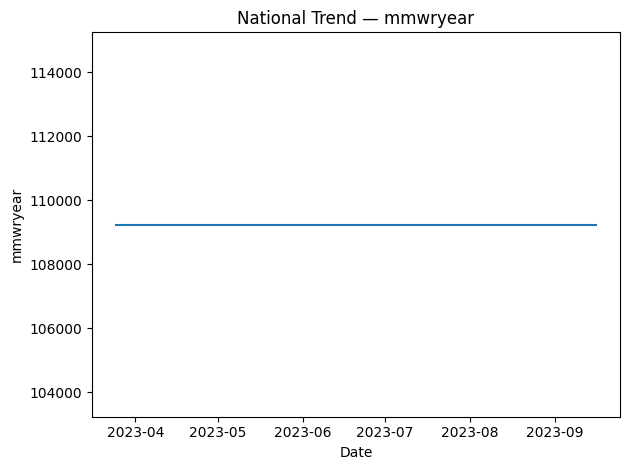

In [164]:
# National trend on first numeric column (if present)
if NUM_COLS:
    val_col = NUM_COLS[0]
    daily = df.groupby(DATE_COL)[val_col].sum(min_count=1).dropna()

    fig, ax = plt.subplots()
    ax.plot(daily.index, daily.values)
    ax.set_title(f"National Trend — {val_col}")
    ax.set_xlabel("Date"); ax.set_ylabel(val_col)
    plt.tight_layout()
else:
    print("[info] No numeric column detected; skipping national trend plot.")

In [166]:
# Top-10 entities in last 14 days (requires geo + a numeric)
if GEO_COL and NUM_COLS:
    val_col = NUM_COLS[0]
    recent = df[df[DATE_COL] >= (latest - pd.Timedelta(days=14))]
    top10 = (recent.groupby(GEO_COL)[val_col]
             .sum(min_count=1)
             .dropna()
             .sort_values(ascending=False)
             .head(10))
    top10
else:
    top10 = pd.Series(dtype=float)
    print("[info] No GEO or numeric column detected; skipping top entities.")

[info] No GEO or numeric column detected; skipping top entities.


## 8) Interpretation table

In [169]:
interp = pd.DataFrame(
    [("Timeliness (14d)", timeliness_14d, "Share of rows within last 14 days relative to dataset latest."),
     ("Completeness",     completeness,   "Average non-null across date/geo/measures.")],
    columns=["Metric","Score","What it means"]
)

def color_score(val):
    try: x = float(val)
    except Exception: return ""
    if x < 0.70:  return "background-color:#fde2e1; color:#8a0f0a;"
    if x < 0.90:  return "background-color:#fff4cc; color:#7a5a00;"
    return "background-color:#e6f4ea; color:#0b5f2a;"

display(interp.style.format({"Score":"{:.2f}"}).map(color_score, subset=["Score"]))

,Metric,Score,What it means
0,Timeliness (14d),0.12,Share of rows within last 14 days relative to dataset latest.
1,Completeness,1.00,Average non-null across date/geo/measures.


## 9) Save artifacts (for Notebook 04 & dashboards)

In [172]:
# Raw rows for reuse
(DATA_DIR / "cdc_summary.json").write_text(json.dumps(raw_rows, default=str, indent=2))

# Flat CSV with a predictable shape
save_cols = [DATE_COL] + ([GEO_COL] if GEO_COL else []) + (NUM_COLS if NUM_COLS else [])
df[save_cols].to_csv(DATA_DIR / "cdc_cases_flat.csv", index=False)

# ... after normalize_rows(...)
summary = {
    "source": df_source,
    "n_rows": int(len(df)),
    "date_from": str(df[DATE_COL].min().date()) if not df.empty else None,
    "latest_date": str(latest.date()) if pd.notna(latest) else None,
    "timeliness_14d": float(timeliness_14d),
    "completeness_key": float(completeness),
    "top_entities_14d": top10.to_dict() if isinstance(top10, pd.Series) else {},
    "date_col": DATE_COL,
    "geo_col": GEO_COL if GEO_COL else ("state" if "state" in df.columns else None),  # <-- ensure geo present
    "num_cols": NUM_COLS
}

(DATA_DIR / "cdc_cases_summary.json").write_text(json.dumps(summary, indent=2))

print("Saved:")
print(" - data/cdc_summary.json        (raw rows)")
print(" - data/cdc_cases_flat.csv      (tidy slice)")
print(" - data/cdc_cases_summary.json  (metrics + dates + top entities)")

Saved:
 - data/cdc_summary.json        (raw rows)
 - data/cdc_cases_flat.csv      (tidy slice)
 - data/cdc_cases_summary.json  (metrics + dates + top entities)
